# PerturbationX
PerturbationX is a package for analyzing causal networks in combination with gene expression data. It is based on the [TopoNPA](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4227138/) algorithm. It was developed as part of a Master's thesis at the University of Ljubljana, Faculty of Computer and Information Science and in collaboration with the National Institute of Biology. This notebook demonstrates the use of PerturbationX for analyzing a small causal network.

## Installation
The package can be installed from PyPI or directly from GitHub. It requires a Python version of 3.10 or newer. It is based on NetworkX and pandas and requires Cytoscape for visualization. The latter can be downloaded from [here](https://cytoscape.org/download.html).

```bash
python -m pip install perturbationx # PyPI
python -m pip install git+https://github.com/mikethenut/perturbationx # GitHub
```

## Network import
For demonstration purposes, a small example network with accompanying datasets is included in the package. The network core is based on the human Osmotic Stress network from the [Causal Biological Networks database](https://www.causalbionet.com/), available under Network ID [osmotic_stress_2.0_hs](https://www.causalbionet.com/Home/NetworkVisualization/networkGraph?ID=osmotic_stress_2.0_hs). All non-causal edges were removed and the largest connected component was then selected. The network boundary and datasets were generated synthetically and do not correspond to any real biological system.

In [1]:
import perturbationx as px
from perturbationx import CausalNetwork

core_network_file = px.resources.get_osmotic_stress_core_path() # path to the network core
boundary_network_file = px.resources.get_osmotic_stress_boundary_path() # path to the network boundary
osmotic_stress_network = CausalNetwork.from_tsv(core_network_file, edge_type="core")
osmotic_stress_network.add_edges_from_tsv(boundary_network_file, edge_type="boundary")

In this example, we imported core and boundary edges separately. The files contain three columns, with a header row of 'subject', 'object', and 'relation'. Adding a 'type' column would allow us to concatenate the files and import them in one step. When the input file specifies valid edge types in this way, the argument passed to the import function is ignored.

A CausalNetwork can also be instantiated from CSV files (from_csv), other delimited files (from_dsv), Cytoscape json files (from_cyjs_json), NetworkX graphs (from_networkx), and pandas DataFrames (from_pandas). Refer to the documentation for more information.

## Network manipulation
We can now inspect the network. We will first look at the number of nodes and edges.

In [2]:
node_count = osmotic_stress_network.number_of_nodes()
core_node_count = osmotic_stress_network.number_of_nodes(typ="core")
edge_count = osmotic_stress_network.number_of_edges()
core_edge_count = osmotic_stress_network.number_of_edges(typ="core")

print(f"Number of nodes: {node_count}, {core_node_count} of which are core nodes.")
print(f"Number of edges: {edge_count}, {core_edge_count} of which are core edges.")

Number of nodes: 131, 0 of which are core nodes.
Number of edges: 436, 40 of which are core edges.


Wait, why does the network report zero core nodes? This is because node types are inferred dynamically during computation. While the network contains 131 nodes, none of them are currently assigned to the core or boundary. In order to see what the algorithm will do, we can use the following command.

In [3]:
osmotic_stress_network.infer_graph_attributes(inplace=True)

# Recompute node counts
core_node_count = osmotic_stress_network.number_of_nodes(typ="core")
boundary_node_count = osmotic_stress_network.number_of_nodes(typ="boundary")

print(f"The network contains {core_node_count} core nodes and {boundary_node_count} boundary nodes.")

2023-11-01 10:48:39,609 INFO -- core edges: 40
2023-11-01 10:48:39,610 INFO -- boundary edges: 396
2023-11-01 10:48:39,611 INFO -- core nodes: 31
2023-11-01 10:48:39,612 INFO -- outer boundary nodes: 100
2023-11-01 10:48:39,613 INFO -- core nodes with boundary edges (inner boundary): 10
The network contains 31 core nodes and 100 boundary nodes.


As we can see, the nodes are now correctly assigned. We obtained the same statistics from internal logs. Logging is enabled by default and can be disabled by setting `verbose=False`.

Next, let's try adding a new edge to the network.

In [4]:
src, trg = 'a(CHEBI:"hydrogen peroxide")', 'a(SCHEM:Dinoprostone)'
osmotic_stress_network.add_edge(src, trg, '1.0')

for edge in osmotic_stress_network.edges():
    v1, v2, data = edge
    if v1 == src and v2 == trg:
        print("New edge: " + str(edge))

New edge: ('a(CHEBI:"hydrogen peroxide")', 'a(SCHEM:Dinoprostone)', {'relation': '1.0', 'type': 'infer'})


The edge was successfully added, however its type was set to 'infer'. Let's specify the edge's type to prevent any errors during computation.

In [5]:
osmotic_stress_network.modify_edge(src, trg, typ='core')

for edge in osmotic_stress_network.edges():
    v1, v2, data = edge
    if v1 == src and v2 == trg:
        print("Updated edge: " + str(edge))

Updated edge: ('a(CHEBI:"hydrogen peroxide")', 'a(SCHEM:Dinoprostone)', {'relation': '1.0', 'type': 'core'})


We specified the edge relation as `1.0`. This is the causal relationship between vertices and is used to assign edge weights during computation. By default, numeric parsing is enabled to allow setting weights directly. The default settings also map `increases`, `directlyIncreases`, `->` and `=>` to a weight of 1.0, and `decreases`, `directlyDecreases`, `-|` and `=|` to a weight of -1.0. Different syntax can be used, however the mapping must be specified by correctly configuring the `RelationTranslator` class and passing it to the causal network. Unexpected relations will be mapped to a weight of zero, indicating no causal relationship. Refer to the documentation for more information.

## Computing the NPA score

Let's remove the extra edge and import our test datasets.

In [6]:
osmotic_stress_network.remove_edge(src, trg)

import pandas as pd

datasets = dict()
idx = 1
for dataset_path in px.resources.get_osmotic_stress_dataset_paths():
    data_name = "test_%d" % idx
    datasets[data_name] = pd.read_table(dataset_path)
    idx += 1

The implemention expects datasets to be passed as a dictionary of pandas DataFrames. Each DataFrame should contain at least the columns `nodeID` and `logFC`, however `t` or `stderr` are also required for computing statistics. We will now pass our dataset map to the network and begin computation.

In [7]:
test_results = osmotic_stress_network.toponpa(datasets)

2023-11-01 10:48:46,151 INFO -- PREPROCESSING NETWORK
2023-11-01 10:48:46,164 INFO -- core edges: 40
2023-11-01 10:48:46,165 INFO -- boundary edges: 396
2023-11-01 10:48:46,165 INFO -- core nodes: 31
2023-11-01 10:48:46,166 INFO -- outer boundary nodes: 100
2023-11-01 10:48:46,166 INFO -- core nodes with boundary edges (inner boundary): 10
2023-11-01 10:48:46,760 INFO -- COMPUTING NPA FOR DATASET 'test_1'
2023-11-01 10:48:46,764 INFO -- boundary nodes matched with dataset: 100
2023-11-01 10:48:46,765 INFO -- boundary edges remaining: 385
2023-11-01 10:48:46,766 INFO -- core nodes with boundary edges remaining: 7
2023-11-01 10:48:48,182 INFO -- COMPUTING NPA FOR DATASET 'test_2'
2023-11-01 10:48:48,185 INFO -- boundary nodes matched with dataset: 100
2023-11-01 10:48:48,186 INFO -- boundary edges remaining: 385
2023-11-01 10:48:48,187 INFO -- core nodes with boundary edges remaining: 7
2023-11-01 10:48:49,545 INFO -- COMPUTING NPA FOR DATASET 'test_3'
2023-11-01 10:48:49,549 INFO -- bou

Results contain four types of information: global, node, distribution, and metadata. Let's first take a look at global and node information.

In [15]:
display(test_results.global_info())

print(test_results.node_attributes())
display(test_results.node_info("test_3"))

,NPA,variance,ci_lower,ci_upper,k2_value,o_value
test_1,0.028576,0.309515,-1.061831,1.118983,0.022,0.012
test_2,0.117399,0.016193,-0.132009,0.366806,0.002,0.000
test_3,1.750560,8.072700,-3.818187,7.319307,0.002,0.000


['contribution', 'coefficient', 'variance', 'ci_lower', 'ci_upper', 'p_value']


attr,contribution,coefficient,variance,ci_lower,ci_upper,p_value
p(HGNC:AQP3),0.012135,-0.651810,0.238653,-1.609295,0.305674,0.091061
"kin(p(SFAM:""PRKA Family""))",0.057843,-0.711537,0.270254,-1.730444,0.307369,0.085545
"kin(p(SFAM:""MAPK Erk1/2 Family""))",0.060674,-0.651810,0.238653,-1.609295,0.305674,0.091061
p(HGNC:NRG1),0.032483,-0.795125,0.396958,-2.029992,0.439742,0.103472
p(HGNC:SLC6A12),0.031004,-0.758725,0.892567,-2.610416,1.092967,0.210962
kin(p(HGNC:MAPK14)),0.027421,-0.692837,0.354713,-1.860148,0.474474,0.122353
p(HGNC:AQP1),0.025605,-0.669498,0.319636,-1.777589,0.438594,0.118169
"p(HGNC:CFTR,pmod(P,S,768))",0.028921,0.711537,0.270254,-0.307369,1.730444,0.085545
p(HGNC:AKR1B1),0.013488,-0.687185,0.441027,-1.988795,0.614424,0.150390
cat(p(HGNC:ERBB3)),0.021159,-0.571884,0.170333,-1.380789,0.237021,0.082924


The datasets all have nonsensical variance due to their synthetic nature. Regardless, we can see that the NPA scores vary significantly. For the dataset with the lowest score, the permutation tests produced p-values above `0.05`, indicating that the result is not significant.

Node information is accessed by specifying either the name of a dataset or a node attribute. The TopoNPA algorithm assigns six attributes per dataset: contribution, coefficient, variance, lower and upper confidence interval limits, and p-values. The last four are all derived from standard error and are thus unrealistic in this example. Coefficients are counterparts to the `logFC` values we provided for boundary nodes. Contributions are estimates of how important a node is for the total NPA score. Since we have a lot of nodes, we might want to look at only the ones with the highest contribution.

In [14]:
leading_nodes_2 = test_results.get_leading_nodes("test_2")
leading_nodes_3 = test_results.get_leading_nodes("test_3")

print("Leading nodes for both datasets: " + str(leading_nodes_2.intersection(leading_nodes_3)))
print("Leading nodes for only dataset 2: " + str(leading_nodes_2.difference(leading_nodes_3)))
print("Leading nodes for only dataset 3: " + str(leading_nodes_3.difference(leading_nodes_2)))

Leading nodes for both datasets: {'p(HGNC:AQP5)', 'kin(p(SFAM:"PRKA Family"))', 'kin(p(SFAM:"MAPK Erk1/2 Family"))', 'a(SCHEM:Dinoprostone)', 'p(HGNC:NRG1)', 'a(CHEBI:"hydrogen peroxide")', 'tport(p(HGNC:CFTR))', 'tscript(p(HGNC:NFAT5))', 'bp(GOBP:"hyperosmotic response")', 'p(HGNC:SLC6A12)', 'tscript(p(HGNC:HIF1A))', 'kin(p(HGNC:MAPK14))', 'kin(p(HGNC:ATM))', 'p(HGNC:AQP1)', 'p(HGNC:CFTR,pmod(P,S,768))'}
Leading nodes for only dataset 2: {'cat(p(HGNC:ERBB3))'}
Leading nodes for only dataset 3: {'cat(p(HGNC:PTGES2))', 'cat(p(HGNC:PTGS2))', 'p(HGNC:EGF)'}


Comparing leading nodes between the two datasets with significant results, we can see that there is a high degree of conformity. While this is not guaranteed (especially when using synthetic data), it is likely that the same nodes will show up across different datasets.

Next, let's take a look at permutation test distributions.

In [17]:
print(test_results.distributions())

['k2', 'o']


By default, two permutation tests are computed. The `O` permutation test shuffles input data and tests the importance of its ordering. The `K2` permutation test shuffles core edges according to the degree sequence and tests the importance of the core network structure. A `K1` test is also available, which shuffles edges completely at random. The tests can be further adjusted by specifying optional arguments for computation. Refer to the documentation for more information.

<Figure size 640x480 with 0 Axes>

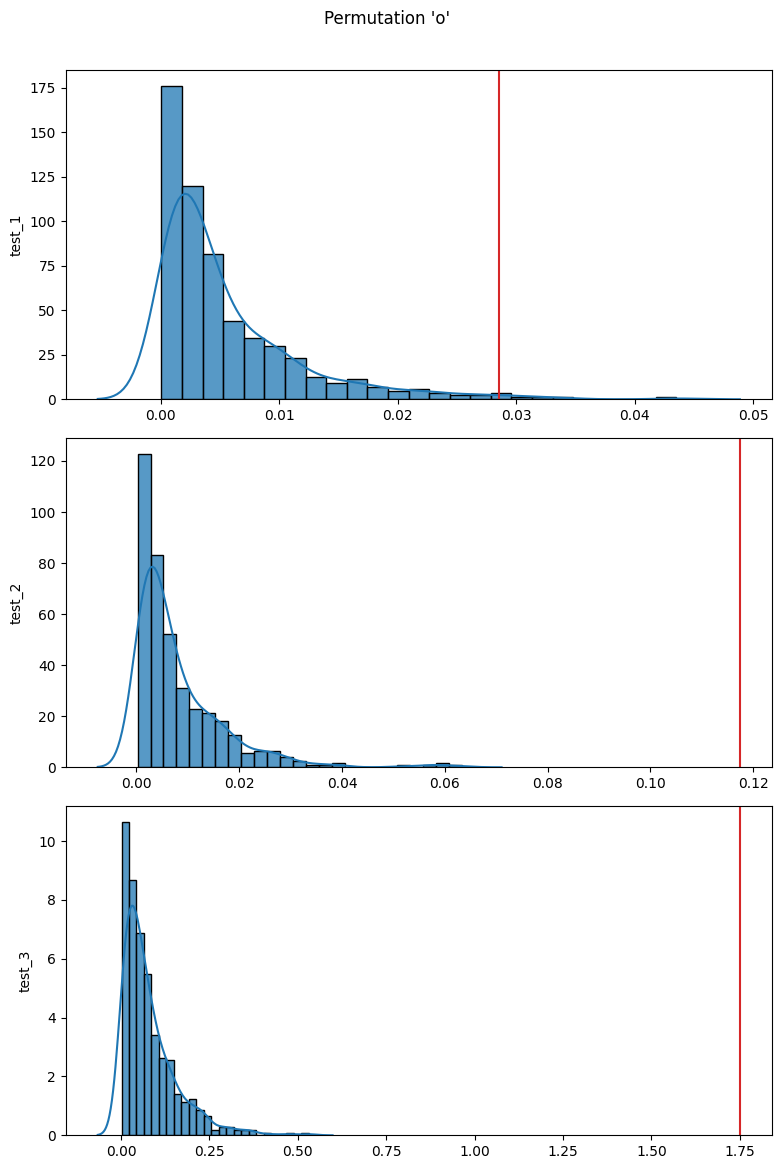

array([<Axes: ylabel='test_1'>, <Axes: ylabel='test_2'>,
       <Axes: ylabel='test_3'>], dtype=object)

In [18]:
test_results.plot_distribution('o')

<Figure size 640x480 with 0 Axes>

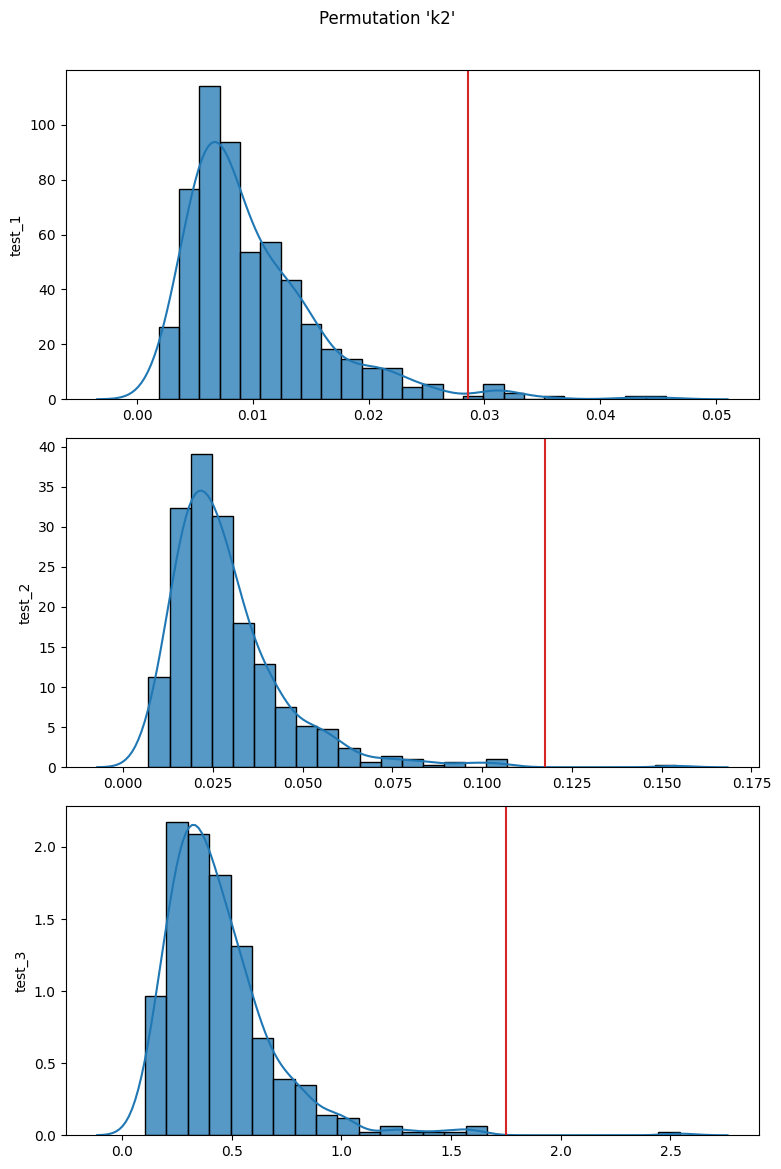

array([<Axes: ylabel='test_1'>, <Axes: ylabel='test_2'>,
       <Axes: ylabel='test_3'>], dtype=object)

In [19]:
test_results.plot_distribution('k2')

In [8]:
import py4cytoscape as p4c
p4c.cytoscape_version_info()

2023-09-16 15:49:15,949 DEBUG -- Calling cytoscape_version_info()
2023-09-16 15:49:15,951 DEBUG -- ǀCalling cyrest_get('version', base_url='http://127.0.0.1:1234/v1')
2023-09-16 15:49:15,953 DEBUG -- ǀHTTP GET(http://127.0.0.1:1234/v1/version)
2023-09-16 15:49:15,962 DEBUG -- ǀOK[200], content: {"apiVersion":"v1","cytoscapeVersion":"3.10.1"}
2023-09-16 15:49:15,964 DEBUG -- ǀReturning 'cyrest_get': {'apiVersion': 'v1', 'cytoscapeVersion': '3.10.1'}
2023-09-16 15:49:15,966 DEBUG -- Returning 'cytoscape_version_info': {'apiVersion': 'v1', 'cytoscapeVersion': '3.10.1', 'automationAPIVersion': '1.6.0', 'py4cytoscapeVersion': '1.6.0'}
2023-09-16 15:49:15,967 DEBUG -- --------------------


{'apiVersion': 'v1',
 'cytoscapeVersion': '3.10.1',
 'automationAPIVersion': '1.6.0',
 'py4cytoscapeVersion': '1.6.0'}

In [29]:
display = results.display_network(display_boundary=False)

Applying default style...
Applying preferred layout


In [30]:
display.highlight_leading_nodes("CS (5m)", cutoff=0.3)

58492

In [31]:
display.extract_leading_nodes("CS (5m)", cutoff=0.3, include_neighbors=2, neighborhood_type="intersection")

58492

In [28]:
display.extract_leading_nodes("CS (5m)", cutoff=0.3, include_neighbors=1, neighborhood_type="union")

56460

In [22]:
import logging
logging.disable(logging.DEBUG)
display.extract_leading_nodes("CS (5m)", cutoff=0.3, include_shortest_paths="directed")

52364

In [25]:
import logging
logging.disable(logging.DEBUG)
display.extract_leading_nodes("CS (5m)", cutoff=0.3, include_shortest_paths="all", path_length_tolerance=1)

54428

In [9]:
display.color_nodes("CS (5m)", "contribution")

8168

In [5]:
results.export("results.json")